In [5]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../scripts')
from tqdm import tqdm
import evaluate, utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import tensorflow as tf
import json
import metrics, evaluate, saliency_embed
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
import global_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# BPNet bin loss plot

In [9]:
summary_performance = pd.concat([pd.read_csv(f) for f in ['../paper_tables/model_evaluations/ADDED_bin_loss_40.csv',
                                               '../paper_tables/model_evaluations/bin_loss_40.csv']])


average_summary_performance = summary_performance[(summary_performance['pred type'] == 'raw')&
                                                  (summary_performance['eval type'] == 'whole')
                                                  ].groupby(['bin_size', 'loss_fn']).mean().reset_index()

loss_name_subs = {'basenjipearsonr': 'pearson\'s r', 'mse': 'MSE',
                  'multinomialnll_mse_reg':'multinomial NLL + MSE',
                 'poisson':'poisson NLL', 'pearsonr_mse': 'pearson\'s r + MSE'}

average_summary_performance['loss'] = [loss_name_subs[l] for l in average_summary_performance['loss_fn'].values]

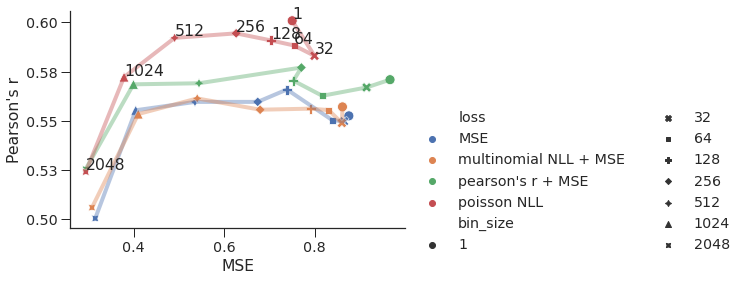

In [35]:
sns.set(font_scale=1.3)  
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True


df = average_summary_performance[average_summary_performance['loss']!='pearson\'s r']
lines = sns.lineplot(data=df.sort_values('bin_size'), x='mse', 
                     y='pr_corr', hue='loss', sort=False, legend=False, linewidth=4, alpha=0.4)

points = sns.scatterplot(data=df, x='mse', y='pr_corr', hue='loss', 
                         ax=lines, legend='full', s=100, style='bin_size')

points.legend(frameon=False, bbox_to_anchor=(1,0.6), ncol=2)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylabel('Pearson\'s r')
plt.xlabel('MSE')

for item in df[df['loss']=='poisson NLL'].groupby('bin_size'):
    #item[1] is a grouped data frame
    for x,y,m in item[1][['mse','pr_corr','bin_size']].values:
        points.text(x,y+0.001,int(m))
        
        
# plt.xlim(1.12,1.75)
points.yaxis.set_major_locator(MaxNLocator(5)) 
points.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
points.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.savefig('bpnet_binloss.svg')

# smoothen traingle plot

In [ ]:
smoothen_results = pd.read_csv('../intermediate_results/smoothen_results_basenji.csv')


# UMAP embeddings

In [3]:
testset, targets = evaluate.collect_whole_testset('../data/15_ATAC_chr8/', coords=True)
np_C, np_X, np_Y = utils.convert_tfr_to_np(testset)
threshold = 2

2022-03-17 15:50:51.587773: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 15:50:52.070756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 125 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c1:00.0, compute capability: 8.6


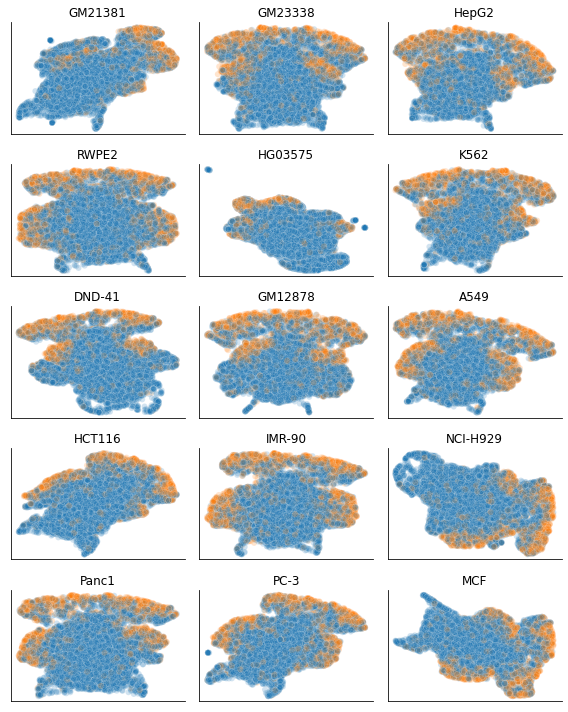

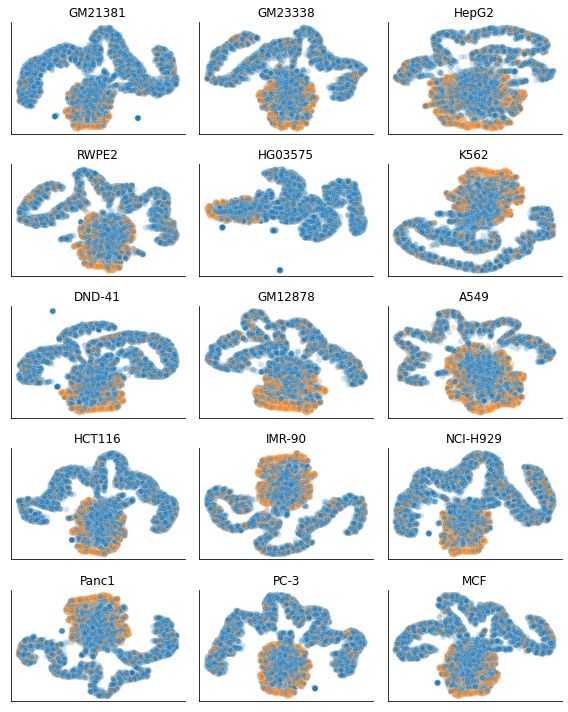

In [4]:
run_path_1 = glob.glob('../../wandb/*/run-20211023_095131-w6okxt01')[0] # residual model
df = pd.read_csv('../paper_tables/model_evaluations/binloss_basenji.csv')
run_path_2 = glob.glob('../../wandb/*/'+os.path.basename(df[(df['loss_fn']=='poisson')&(df['bin_size']==32)]['run_dir'].values[0]))[0]
for run_path in [run_path_1, run_path_2]:
    # load and get model layer
    layer = -3
    model, bin_size = utils.read_model(run_path, compile_model=False)
    aux_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

    umap_dir = utils.make_dir('umap_embeddings')
    out_dir = utils.make_dir(os.path.join(umap_dir, os.path.basename(run_path)))


    for cell_line in range(len(targets)):
        csv_filepath = os.path.join(out_dir, str(cell_line)+'_UMAP_embeddings.csv')

        if os.path.isfile(csv_filepath):
            embeddings = pd.read_csv(csv_filepath)
        else:
            print(targets[cell_line])
            thresholded_C, thresholded_X, thresholded_Y = utils.threshold_cell_line_np(np_C, 
                                                                                       np_X, 
                                                                                       np_Y, 
                                                                                       cell_line, 
                                                                                       more_than=threshold)
            idr_class = saliency_embed.label_idr_peaks(thresholded_C, cell_line, bedfile1='../data/15_ATAC_chr8/sequences.bed', 
                                                       bedfile2='../data/cell_line_specific_test_sets/cell_line_13/complete/peak_centered/i_2048_w_1.bed', 
                                                       fraction_overlap=0.5)
            predictions = utils.predict_np(thresholded_X, model, batch_size=32, reshape_to_2D=False)
            interm_representations = utils.predict_np(thresholded_X, aux_model, batch_size=32, reshape_to_2D=True)

            embeddings = saliency_embed.get_embeddings(interm_representations)
            embeddings['IDR'] = idr_class
            embeddings['cell line'] = targets[cell_line]
            embeddings.to_csv(csv_filepath, index=None)
    nrows, ncols = 5, 3
    fig = plt.figure(figsize=[8,10])    
    for i, cell_line in enumerate(targets):
        csv_filepath = os.path.join(out_dir, str(i)+'_UMAP_embeddings.csv')
        data = pd.read_csv(csv_filepath)
        ax = fig.add_subplot(nrows, ncols, i+1)
        sns.scatterplot(data=data, x='UMAP 1', y='UMAP 2', hue='IDR', ax=ax, alpha=0.2)

        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.get_legend().remove()
    #     ax.set_axis_off()
        ax.set_title(cell_line)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'per_cell_line.png'))

# occlusion experiments

In [2]:
testset, targets = evaluate.collect_whole_testset('../data/15_ATAC_chr8/', coords=True)
np_C, np_X, np_Y = utils.convert_tfr_to_np(testset)
threshold = 2

2022-03-17 17:20:47.375016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-17 17:20:47.880384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14257 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:c1:00.0, compute capability: 8.6


In [3]:
mask = np_Y.reshape((-1, 2048*15)).max(axis=1) > threshold

In [4]:
X_set = np_X[mask] 

In [5]:
run_path = '../paper_runs/new_models/32_res/run-20211023_095131-w6okxt01'
model,_ = utils.read_model(run_path)

In [6]:
gi = global_importance.GlobalImportance(model, targets)

gi.occlude_all_motif_instances(X_set, ['TGA.TCA'], 
                                      num_sample=10000)

tandem_motifs_to_remove ['TGA.TCA']
TGA.TCA


10000it [02:04, 80.01it/s]
2022-03-17 17:23:31.833227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-03-17 17:23:33.338552: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
results = pd.concat(gi.summary_remove_motifs)

results['N instances'] = [int(r) for r in results['N instances'].values]

In [8]:
results.to_csv('occlusion.csv')

In [2]:
results = pd.read_csv('occlusion.csv')

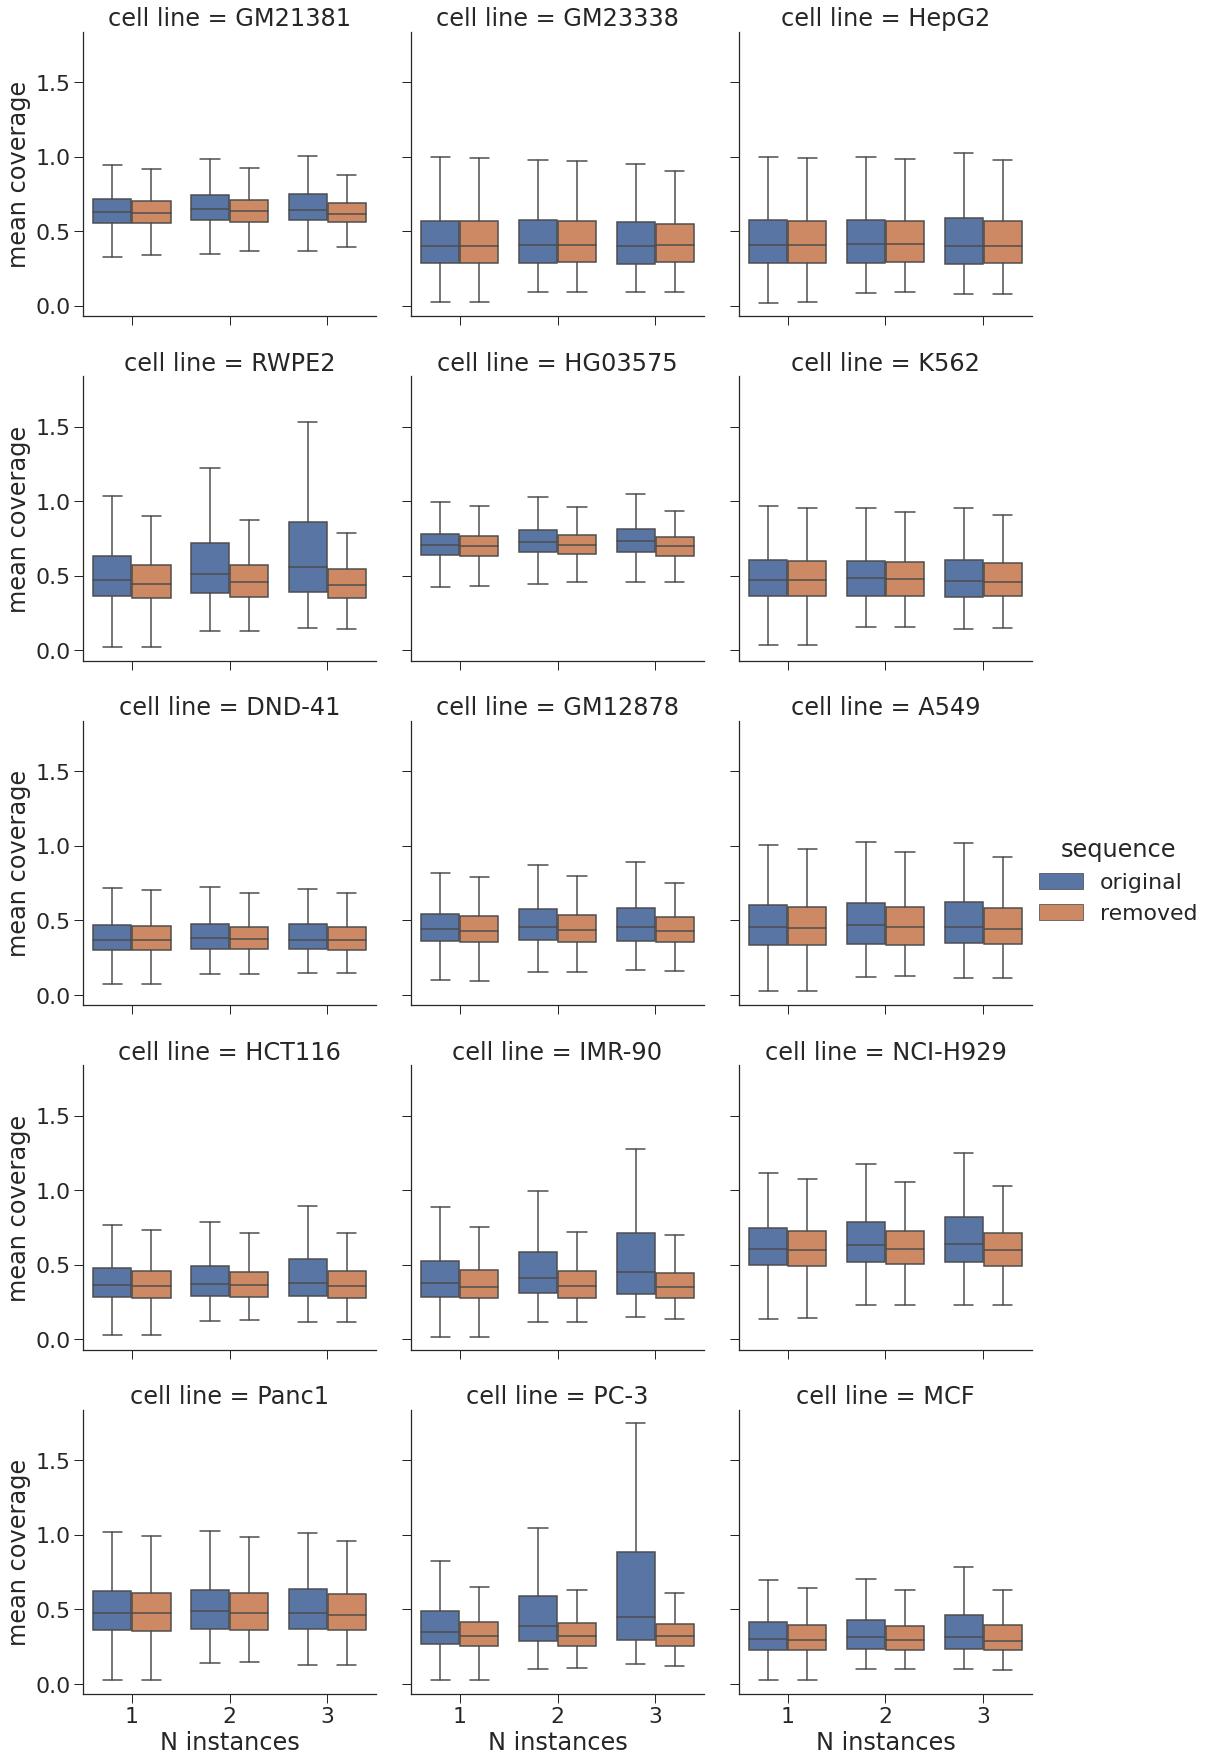

In [5]:
sns.set(font_scale=2)  
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

sns.catplot(data=results[results['N instances']<4], x='N instances', y='mean coverage', 
            showfliers=False, hue='sequence', kind='box', col='cell line', col_wrap=3)
plt.savefig('occlude_results.pdf')

In [15]:
len(set(results[results['cell line']=='PC-3']['seq_idx'].values))

5110

In [25]:
import collections

In [28]:
collections.Counter(results[(results['cell line']=='HepG2') & (results['sequence']=='original')]['N instances'])

Counter({1: 3381, 2: 1310, 3: 323, 4: 66, 5: 14, 7: 3, 8: 5, 6: 8})

# GIA addition supplements

In [29]:
model_dict = {'run-20211019_161849-9ygdmjss':'mod_binary',
             'run-20210825_040148-nieq47kf': 'basset',
             'run-20211023_095131-w6okxt01': '32_new',
             'run-20210923_162932-56p3xy2p':'basenji',
              'run-20211013_133014-ku9mdrht': 'bpnet'
             }

/tmp/ipykernel_1493372/3377202309.py:38: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1493372/3377202309.py:38: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1493372/3377202309.py:38: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1493372/3377202309.py:38: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


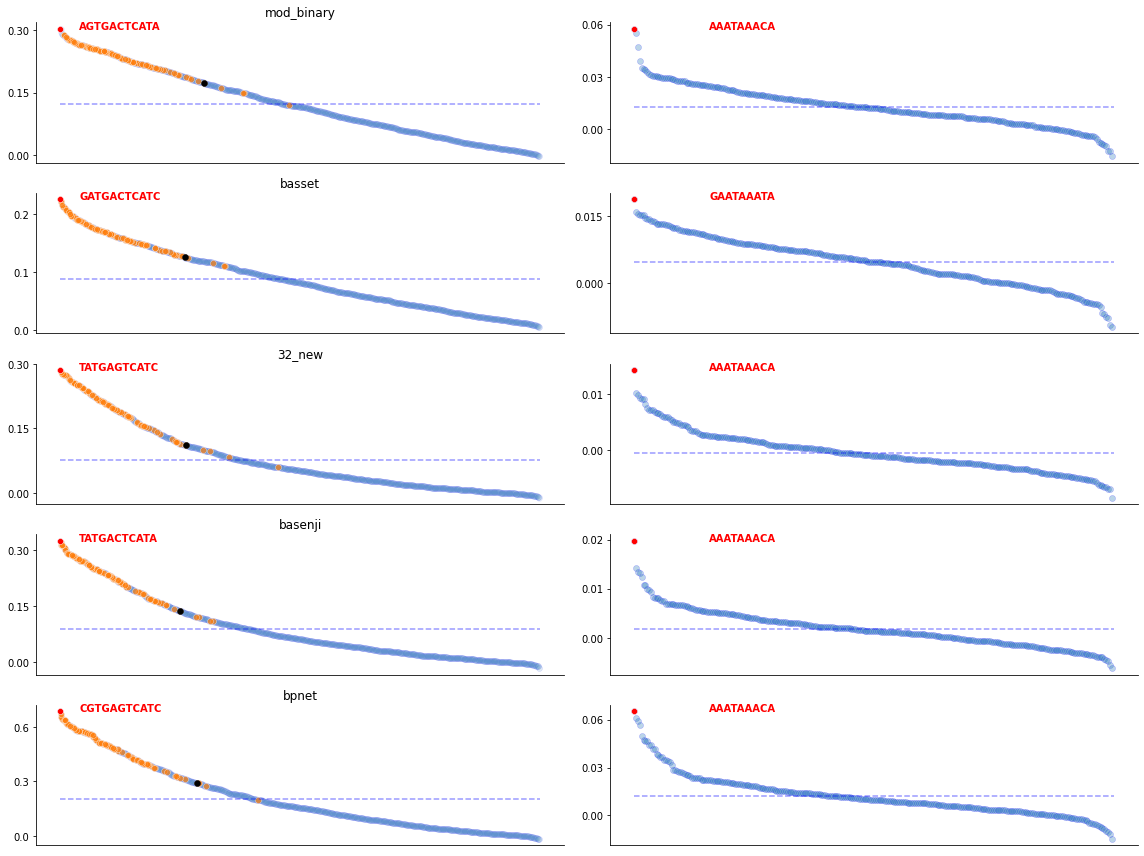

In [41]:
# flanks
cell_line = 'PC-3'
nrows, ncols = 5, 2
fig = plt.figure(figsize=[16,12])    
pointer = 1
for run_name in model_dict.keys():
# run_name = 'run-20211023_095131-w6okxt01'
    for i, motif_insert in enumerate([[('TGA', 1024), ('TCA', 1024+len('TGA')+1)], [('ATAAA', 1024)]]):
        if i ==0:
            alpha=0.07
        else:
            alpha=0.3
        motif_pattern = '.'.join([m[0] for m in motif_insert])
        ax = fig.add_subplot(nrows, ncols, pointer)
        flanks = pd.read_csv('../intermediate_results/add_GIA_interaction/{}/PC-3_..{}../dinuc_N1000/flanks.csv'.format(run_name, motif_pattern))
        sorted_flanks = flanks[flanks['cell line']==cell_line].sort_values('mean difference')[::-1]
        sns.scatterplot(data=sorted_flanks, 
                        x='motif', y='mean difference', edgecolor='blue', alpha=alpha, ax=ax)
        mean_of_all = sorted_flanks['mean difference'].mean()
        plt.hlines(mean_of_all,0, len(sorted_flanks['motif'].values), 'blue', linestyles='--', alpha=0.4)

        plt.text(40, sorted_flanks.iloc[0,1], sorted_flanks.iloc[0,0], 
             horizontalalignment='left', size='medium', color='red', weight='semibold')

        if i == 0:
            pc3 = flanks[flanks['cell line']==cell_line].reset_index()
            jaspar_motifs = []
            for r, row in pc3.iterrows():
                m = row['motif']
                if m[0] in 'GAT' and m[1] in 'GAC' and m[5] in 'CG' and m[9] in 'TC' and m[10] in 'CGT':
                    jaspar_motifs.append(r)
            sns.scatterplot(data=pc3.iloc[jaspar_motifs], x='motif', y='mean difference', alpha=0.7, ax=ax)
            point_at_min = pc3.iloc[jaspar_motifs].sort_values('mean difference').iloc[4]
            p = np.argwhere(sorted_flanks['motif'].values==point_at_min['motif'])[0][0]
            point_df = sorted_flanks.iloc[p].to_frame().T
            sns.scatterplot(data=point_df, x='motif',
                            y='mean difference', color='k', edgecolor=None, ax=ax)
        plt.xticks([])
        a = sns.scatterplot(x=[0],y=[sorted_flanks.iloc[0,1]], color='r')
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        plt.ylabel('')
        plt.xlabel('')
        pointer += 1
        if i == 0:
            ax.set_title(model_dict[run_name])
        ax.yaxis.set_major_locator(MaxNLocator(3))


#         plt.savefig('7a_{}.svg'.format(i))
plt.tight_layout()

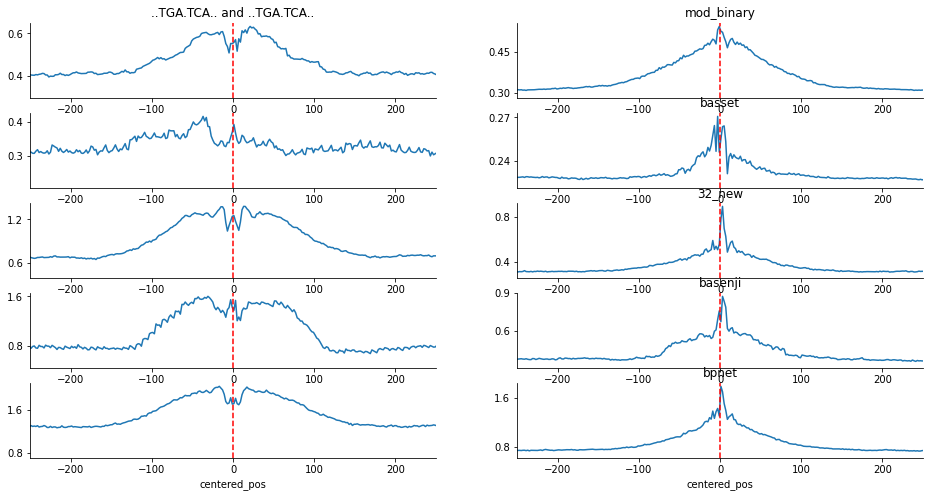

In [37]:

m1_s = 1024
m1 = '..TGA.TCA..'
cell_line = 'PC-3'


nrows, ncols = 5, 2
fig = plt.figure(figsize=[16,8])    
pointer = 1
for run_id, run_name in enumerate(model_dict.keys()):
    for m2 in ['..TGA.TCA..', '..ATAAA..']:
        ax = fig.add_subplot(nrows, ncols, pointer)
        df = pd.read_csv('../intermediate_results/add_GIA_interaction/{}/{}_{}_and_{}/dinuc_N1000/1024_distance.csv'.format(run_name, cell_line, m1, m2))
        df['insertion position'] = [int(d.split('_')[1]) for d in df['motif 2']]
        dist_df = df[df['cell line']==cell_line].reset_index()
        pos = dist_df['insertion position'].values
        dist_df = dist_df.iloc[np.argwhere((pos<m1_s-len(m2)+1)|(pos>m1_s+len(m1))).flatten()]
        new_pos_minus = dist_df[dist_df['insertion position']<=m1_s-len(m2)+1]['insertion position'].values - 1024 + len(m2)
        new_pos_plus = dist_df[dist_df['insertion position']>m1_s+len(m1)]['insertion position'].values - 1024 - len(m1)
        dist_df['centered_pos'] = np.concatenate([new_pos_minus, new_pos_plus])  
        sns.lineplot(data=dist_df, x='centered_pos', y='mean difference', ax=ax)
        plt.ylabel('')
        plt.xlim(-250, 250)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if run_id ==0:
            plt.title('{} and {}'.format(m1, m2))
        plt.axvline(x=0, ymin=0, ymax=1, c='r', linestyle='--')
        ax.yaxis.set_major_locator(MaxNLocator(2))
        pointer += 1
        if m2 == '..ATAAA..':
            ax.set_title(model_dict[run_name])
    #     plt.savefig('GIA_b_{}.svg'.format(m2))